<font color='seagreen'>


# Week 4 -- Radiative Transfer, Transmission and Emission
*Please finish and submit this project before the start of class on 27 September 2017.*

This week we will playing with radiative transfer through a planetary atmosphere, using some more and less realistic models that help demonstrate important concepts about transmission, emission, and global energy balance.

In [61]:
import matplotlib.pyplot as plt, numpy as np
import astropy.units as u, astropy.constants as c
import seaborn as sns
from astropy.io import ascii as asc
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette("Set2", 10)
%matplotlib inline

<font color='seagreen'>

This week you will be using tools you have developed in previous weeks. It might be useful to store functions and blocks of code in Python [modules](https://jakevdp.github.io/WhirlwindTourOfPython/13-modules-and-packages.html), which you `import` into your notebook. For example, see the `spectroscopy.py` file in this same directory, and the block of code below.

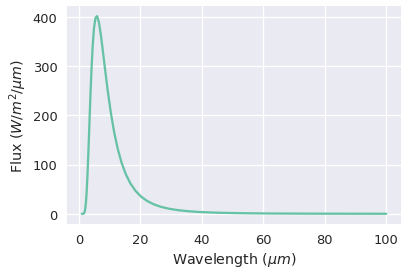

In [62]:
import spectroscopy as spec
w = np.logspace(0,2)*u.um
plt.plot(w, spec.planck_flux(w, 500*u.K))
plt.xlabel('Wavelength ($\mu m$)'); plt.ylabel('Flux ($W/m^2/\mu m$)');

<font color='seagreen'>
### Q1: Transmission through Earth's Atmosphere

The file `earthtransmission.txt` contains a model for the fractional transmittance $t_\lambda$ through Earth's atmosphere, looking straight up from Cerro Paranal in northern Chile. If you want, you can play around and calculate your own models at the [ESO SkyCalc](http://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC). This transmittance $t_\lambda$ is the fraction of light of a given wavelength that makes it through the atmosphere, which we can write as $t_\lambda = I_\lambda({\rm surface})/I_\lambda({\rm above~atmosphere})$. 

+ Plot the transmission through Earth's atmosphere vs. wavelength.
+ Imagine standing on the surface of the Earth with the Sun directly overhead ($\theta_z = 0^\circ$, where $\theta_z$ is the angle away from the zenith). Plot the spectrum of flux we would receive at the surface of the Earth, comparing (in the same panel) the actual flux received to the flux we would receive if there were no atmosphere. (You can approximate the Sun as a perfect thermal emitter with a radius of $1~R_\odot$ and $T_{\odot} = (L_\odot/4\pi R_\odot^2\sigma_{\rm SB})^{1/4}$, at a distance of $1~AU$.)
+ Plot the optical depth $\tau_\lambda$ through Earth's atmosphere, considering a vertical path straight up out of the atmosphere. (Regardless of integration direction, quote this as a positive $\tau$).
+ Derive an expression for the optical depth along a slant path $\tau_{\lambda}(\theta_z)$, if you are looking an angle $\theta_z$ away from zenith. Express $\tau_{\lambda}(\theta_z)$ in terms of the optical depth for a vertical path through the atmosphere. Treat the atmosphere as plane-parallel, meaning that you can ignore the curvature of the Earth. You can assume the atmopshere is in hydrostatic balance and that the mass opacity $\kappa_\lambda$ (in units of $[m^2/kg]$) is constant everywhere throughout the atmosphere.
+ Earth-bound observational astronomers define the quantity "airmass" to be 
$${\rm airmass} = \sec\theta_z$$
where a star that is straight overhead has $\sec\theta_z = 1$ and a star on the horizon has $\sec\theta_z = \infty$. Let's imagine an intrepid astronomer trying to observe a faint star with her telescope. Explain why the star's [airmass](http://astro.swarthmore.edu/plot_airmass.cgi?observatory_string=32.78%3B-105.82%3BMST7MDT%3BApache+Point+Observatory&use_utc=0&observatory_latitude=&observatory_longitude=&timezone=UTC&start_date=09-20-2017&target=Barnard%27s+Star&ra=&dec=&invert=0&max_airmass=2.4) at the planned time of observation would be an important quantity for her to know.
+ Plot the flux spectrum of the Sun seen through Earth's atmosphere at a variety of angles ranging from $\theta_z = 0^\circ$ to $\theta_z = 89^\circ$. Explain why our approximation of a plane-parallel atmosphere makes $\theta_z = 90^\circ$ problematic.
+ Determine the apparent RGB color of the Sun at all these angles, and display those colors in a manner you choose. (You made need to add some interpolation capabilities to your color-calculation code from Week 03, to be able to integrate on multiple different wavelength grids). Discuss the implications for our perception of sunrise/sunset on Earth.
+ Astronomers use [the magnitude system](https://en.wikipedia.org/wiki/Apparent_magnitude) to express differences in brightness. A difference in magnitudes corresponds to a logarithm of their brightness ratios, with the definition that
$$m_1 - m_0 = -2.5\log_{10}\left(\frac{I_1}{I_0}\right)$$
where $m_1$ and $m_0$ are two magnitudes, and $I_1$ and $I_0$ are the intensities corresponding to those magnitudes. How many magnitudes of extinction does a star at $\sec\theta_z = 5$ experience in the astronomical $V$-filter (with a wavelength of roughly $0.55~\mu m$)? What about in the $U$-filter ($0.36~\mu m$)?

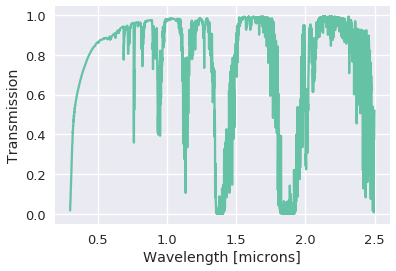

In [63]:
earth_transmit = asc.read('earthtransmission.txt')
# print(earth_transmit)
plt.plot(earth_transmit['wavelength'], earth_transmit['transmission'], '-')
plt.xlabel('Wavelength [microns]')
plt.ylabel('Transmission')

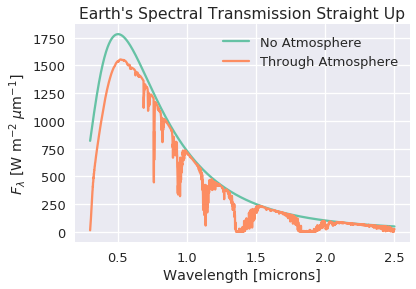

In [64]:
wave = earth_transmit['wavelength']*u.micron
temp_sun = (c.L_sun/(4.0*np.pi*c.sigma_sb*(c.R_sun**2.0)))**(0.25)
sun_flux = 4.0*np.pi*(c.R_sun**2.0)*spec.planck_flux(wave, temp_sun)
sun_received = (sun_flux/(4.0*np.pi*(u.AU**2.0))).to(u.W/(u.micron*(u.m**2.0)))
earth_atm = sun_received*earth_transmit['transmission']
plt.plot(wave, sun_received, label='No Atmosphere')
plt.plot(wave, earth_atm, label='Through Atmosphere')
plt.legend()
plt.xlabel('Wavelength [microns]')
plt.ylabel(r'$F_\lambda$ [W m$^{-2}$ $\mu$m$^{-1}$]')
plt.title('Earth\'s Spectral Transmission Straight Up')

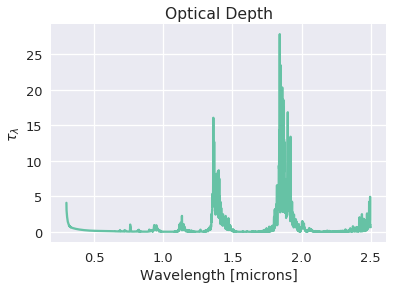

In [65]:
tau_z = -np.log(earth_atm/sun_received)
plt.plot(wave, tau_z)
plt.ylabel(r'$\tau_\lambda$')
plt.xlabel('Wavelength [microns]')
plt.title('Optical Depth')

$\tau_{\lambda}(\theta) = \frac{\tau_{\lambda}}{\cos(\theta)}$

1.74742501084


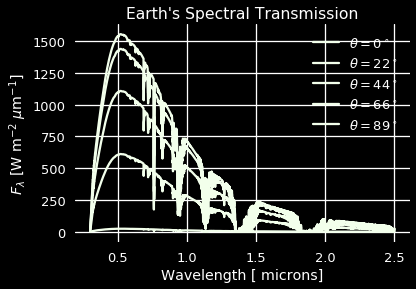

In [74]:
from scipy.interpolate import interp1d
import pandas as pd

df = pd.read_csv('ciexyz31.csv', skiprows=4)
wave_df = np.array(df['wavelength'])*u.nm
x_func = np.array(df[' X'])
y_func = np.array(df[' Y'])
z_func = np.array(df[' Z'])
x_func2 = interp1d(wave_df, x_func, fill_value='extrapolate')
y_func2 = interp1d(wave_df, y_func, fill_value='extrapolate')
z_func2 = interp1d(wave_df, z_func, fill_value='extrapolate')

def xyz2rgb(X, Y, Z):
    '''
    This function converts CIE XYZ values into CIE RGB values.
    '''

    # normalize these, so they're all between 0 and 1
    x = X/(X+Y+Z)
    y = Y/(X+Y+Z)
    z = Z/(X+Y+Z)

    # make a single column matrix containing the x,y,z values
    xyz = np.matrix([x,y,z]).T
    
    # rgb = conversion * xyz (with matrix math)
    conversion = np.matrix([[0.41847, -0.15866, -0.082835],
                            [-0.091169, 0.25243, 0.015708],
                            [0.00092090, -0.0025498, 0.17860]])
    
    # calculate the rgb single-column matrix
    color_matrix = conversion*xyz

    # 
    color = np.array(color_matrix.T)[0]
    color = color/np.max(color)
    
    return color

def convert_flux_rgb(wave, flux):
    wave = wave.to(u.nm)
    flux = flux.to(u.J/(u.s*(u.m**2.0)*u.micron))
    x_comp = np.trapz(flux*x_func2(wave), wave).decompose()
    y_comp = np.trapz(flux*y_func2(wave), wave).decompose()
    z_comp = np.trapz(flux*z_func2(wave), wave).decompose()
    return xyz2rgb(x_comp, y_comp, z_comp)


plt.style.use('dark_background')
plt.figure()
for theta in np.linspace(0.0, 0.99*np.pi/2.0, 5):
    plot_label = r'$\theta = $' + str(int(np.rad2deg(theta))) + '$^\circ$'
    plot_flux = earth_atm*np.cos(theta)
    plt.plot(wave, plot_flux, label=plot_label, color=convert_flux_rgb(wave, plot_flux))
plt.xlabel('Wavelength [ microns]')
plt.ylabel(r'$F_\lambda$ [W m$^{-2}$ $\mu$m$^{-1}$]')
plt.title('Earth\'s Spectral Transmission')
plt.legend()

extinction = -2.5*np.log10(0.2)
print(extinction)

The problem with a plane-parallel atmosphere is that at $\theta=90^{\circ}$, an observer is looking out in the infinite plane.
This results in no flux getting through, whatever the optical depth at $\theta=0$ is, but clearly we see the horizon so the assumption must be flawed.

However, it is true that looking through more air (at greater airmass) is bad for astronomical work. While not extending infinitely, there is more air to look through. The air scatters and blocks more light, and the differential effect of this across wavelength adds more complexity to recovering the true flux received from a target. The fact that my plot is unable to replicate the changing colors of sunlight at different angles is concerning, but I am not sure what to do about it.

For $\sec{\theta} = 5$, the ratio of fluxes $\frac{I_1}{I_0}$, would be $0.2$ no matter what filter. This gives an extinction of $m_1 - m_2 = -2.5\log_{10}{(0.2)} = 1.74$ mags. 

<font color='seagreen'>
### Q2: Emission from Earth's Atmosphere

In this question, we will play with a toy model for understanding the emission spectrum of a planet. Let's imagine a cartoon atmopshere with a $T-P$ profile that follows a power law of the form
$$T(P) = T_{\rm surf}\left(\frac{P}{P_{\rm surf}}\right)^{x}$$

where $P_{\rm surf}$ and $T_{\rm surf}$ are the surface pressure and temperature, and $x$ is some exoponent. A dry adiabat (with constant potential temperature) would be a special case of this generalized $T-P$ profile. 

+ Derive expressions for $\tau_\lambda(P)$ and $T(\tau_\lambda)$ in this atmosphere, in terms of  $P$, $\tau_\lambda$, $\kappa_\lambda$, and $g$ (the gravitational acceleration). You may assume  $\kappa_\lambda$ and $g$ to be constant throughout the atmosphere, and the atmosphere to be in hydrostatic equilibrium. 

+ Write a Python function that numerically integrates the equation of radiative transfer along a vertical path to determine the upwelling intensity $I_\lambda(0)$ leaving the top of the planet's atmosphere. Write this as a line-by-line radiative transfer code, meaning that you will calculate the intensity at one wavelength at a time. For a purely absorbing atmosphere, the equation to solve is
$$I_\lambda(0) = I_\lambda(\tau_{\lambda, {\rm surf}}) e^{-\tau_{\lambda, {\rm surf}}} + \int_{0}^{\tau_{\lambda, {\rm surf}}} B_\lambda (T) e^{-\tau_{\lambda}} d\tau_{\lambda}$$
where $\tau = 0$ corresponds to us observing the atmosphere from above, and $\tau = \tau_{\rm surf}$ corresponds to the optical depth through the atmosphere to the surface. Perform this integral for a single wavelength at a time. Assume that the surface emits as a perfect thermal emitter at temperature $T_{\rm surf}$, so the surface intensity is $I_\lambda(\tau_{\lambda, {\rm surf}}) = B_\lambda(T_{\rm surf})$. Note, it may be helpful to calculate $\tau_{\rm surf, \lambda}$ (the optical depth to the surface). For debugging, think about how your results should change if you vary $\tau_{\rm surf}$. Show that you get roughly $I_{\lambda = 10\mu m} = 3~W/m^2/\mu m/sr$ for a wavelength of $\lambda = 10~\mu m$, if we use values of 
    + $T_{\rm surf} = 280~K$
    + $P_{\rm surf} = 1~bar$
    + $x=1$
    + $\kappa_\lambda = 0.0001~m^2/kg$
    + $g=10~m/s^2$


+ Imagine our atmosphere contains one gas. Let's call it "ceceliapaynium". Its mass opacity is given by the function
$$\kappa_\lambda = \kappa_c \exp \left[-\frac{1}{2}\left(\frac{\lambda - \lambda_c}{\sigma_c}\right)^2 \right]$$
which is opaque near the center of the line at $\lambda_c$ and more transparent for wavelengths farther from the line center. We will start out with $\kappa_c = 0.0001~m^2/kg$, $\lambda_c = 15~\mu m$, $\sigma_c = 1 ~\mu m$. Given this opacity behavior, perform the line-by-line radiative transfer to determine the upward flux from the top of the atmosphere for at least 100 wavelengths spanning $1-100~\mu m$. Plot the spectrum of emitted flux in $[W/m^2/\mu m]$. (Although it is a less accurate approximation here, for this problem we can still assume that $F = \pi I$ to convert from an upward intensity to a flux.)

+ Now, let's vary the temperature structure of the atmosphere. Plot the emission spectra for the three cases of $x=(-1, 0, 1)$. Discuss qualitatively how the appearance of the absorption or emission feature relates to the vertical temperature profile.

+ Integrate your $x=1$ (temperature decreasing with altitude) emission spectrum over wavelength to determine the total flux of outgoing longwave radiation (OLR) in $[W/m^2]$. What is the effective temperature $T_{\rm eff}$ of the planet, given this total OLR? Compare $T_{\rm eff}$ to $T_{\rm surf}$, and discuss the general implications for the effect of an absorbing atmosphere on the surface temperature of a planet.

+ For a planet with fixed $T_{\rm eq}$, discuss qualitatively how the magnitude of the atmosphere's greenhouse warming depends on each of the following parameters. Feel free to use your toy model to help figure this out!
    + $P_{\rm surf}$
    + $x$
    + $\kappa_c$
    + $\sigma_c$    
    + $\lambda_c$


(We're going to use this radiative transfer code again!)